In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib_venn as vn
import seaborn as sns
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

sns.set_color_codes()

### miCLIP data

miCLIP peaks downloaded from GSE63753 as BED files

In [2]:
%%bash
wget -O - \
  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63753/suppl/GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt.gz | \
gzip -d > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cims_peaks.bed
wget -O - \
  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63753/suppl/GSE63753_hek293.sysy.CITS.m6A.12051.bed.gz | \
gzip -d > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cits_peaks.bed

--2018-03-06 16:05:52--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE63nnn/GSE63753/suppl/GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt.gz
           => ‘-’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 2607:f220:41e:250::7
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE63nnn/GSE63753/suppl ... done.
==> SIZE GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt.gz ... 158702
==> PASV ... done.    ==> RETR GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt.gz ... done.
Length: 158702 (155K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 32%  199K 1s
    50K .......... .......... .......... .......... .......... 64%  605K 0s
   100K .......... .......... .......... .......... .......... 96% 86.0M 0s
   150K ....                                                  100% 9503G=0.3s

201

Bedtools intersect used to associate miCLIP peaks with overlapping genes

In [3]:
%%bash
source activate jupyter_python3
CIMS="/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cims_peaks.bed"
CITS="/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cits_peaks.bed"
awk \
  -v OFS="\t" \
  '$3 == "exon" {print $1, $4, $5, $10 "_" $14, ".", $7}' \
  /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_geneset.gtf | \
  sed -e 's/[";]//g' \
  > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_exons.bed

bedtools intersect -wa -wb -s \
  -a /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_exons.bed \
  -b <(cut -f1-6 $CIMS) | \
  sort -k1,1 -k2,2n \
  > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cims_gene_overlap.bed

bedtools intersect -wa -wb -s \
  -a /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_exons.bed \
  -b <(cut -f1-6 $CITS) | \
  sort -k1,1 -k2,2n \
  > /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cits_gene_overlap.bed

In [4]:
m6a_cims = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cims_gene_overlap.bed',
    sep='\t',
    names=['chrom', 'gene_start', 'gene_end', 'gene_id', 'score',
           'strand', 'chrom2', 'm6a_start', 'm6a_end', 'm6a_info',
           'm6a_score', 'strand2'],
    usecols=['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand',
             'm6a_start', 'm6a_end', 'm6a_score'])
exon_nos = m6a_cims.gene_id.str.split('_', expand=True)
m6a_cims['gene_id'] = exon_nos[0]
m6a_cims['exon_no'] = exon_nos[1].astype('i')
m6a_cims.drop_duplicates(['m6a_start', 'm6a_end', 'gene_id'], inplace=True)
m6a_cims.set_index(['chrom', 'm6a_start', 'm6a_end', 'strand'], inplace=True)
m6a_cims.head()

gene_start  gene_end          gene_id  \
chrom m6a_start m6a_end strand                                          
chr1  566859    566860  +           566454    567996  ENSG00000237973   
      569918    569919  +           569756    570302  ENSG00000198744   
      878150    878151  +           877790    878182  ENSG00000187634   
      879954    879955  -           879584    880180  ENSG00000188976   
      934374    934375  -           934342    934812  ENSG00000188290   

                                m6a_score  exon_no  
chrom m6a_start m6a_end strand                      
chr1  566859    566860  +               2        1  
      569918    569919  +               2        1  
      878150    878151  +               2        2  
      879954    879955  -               2       19  
      934374    934375  -              16        3

In [5]:
m6a_cits = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/m6a_cits_gene_overlap.bed',
    sep='\t',
    names=['chrom', 'gene_start', 'gene_end', 'gene_id', 'score',
           'strand', 'chrom2', 'm6a_start', 'm6a_end', 'm6a_info',
           'm6a_score', 'strand2'],
    usecols=['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand',
             'm6a_start', 'm6a_end', 'm6a_score'])
exon_nos = m6a_cits.gene_id.str.split('_', expand=True)
m6a_cits['gene_id'] = exon_nos[0]
m6a_cits['exon_no'] = exon_nos[1].astype('int')
m6a_cits.drop_duplicates(['m6a_start', 'm6a_end', 'gene_id'], inplace=True)
m6a_cits.set_index(['chrom', 'm6a_start', 'm6a_end', 'strand'], inplace=True)
m6a_cits.head()

gene_start  gene_end          gene_id  \
chrom m6a_start m6a_end strand                                          
chr1  569050    569051  +           568915    569121  ENSG00000240409   
      878150    878151  +           877790    878182  ENSG00000187634   
      878276    878277  +           877939    878374  ENSG00000187634   
      934374    934375  -           934342    934812  ENSG00000188290   
      934422    934423  -           934342    934812  ENSG00000188290   

                                m6a_score  exon_no  
chrom m6a_start m6a_end strand                      
chr1  569050    569051  +               4        1  
      878150    878151  +               4        2  
      878276    878277  +               3        4  
      934374    934375  -              17        3  
      934422    934423  -              13        3

In [6]:
all_genes = !awk \
  '{print $10}' /home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/annot/hg19_geneset.gtf | \
  sed -e 's/"//g' -e 's/;//' | \
  paste -s -d','
all_genes = set(all_genes[0].split(','))

### N/C ratio data:
Output from edgeR differential expression analysis (wtap_viriliser_differential_expression_analysis.Rmd):

In [7]:
nuclear_accum = pd.read_table(
    '/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/output/nuclear_accumulation_results.tsv',
    sep='\t')
nuclear_accum = nuclear_accum[nuclear_accum.index.isin(all_genes)]
nuclear_accum.head()

,hgnc_symbol,logFC,logCPM,LR,PValue,FDR,description,CC1,CC2,CC3,CN1,CN2,CN3,VWC1,VWC2,VWC3,VWN1,VWN2,VWN3
ENSG00000000003,TSPAN6,-0.233266,4.547133,1.003614,0.316438,0.706286,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],4.215318,4.495514,4.481094,4.954004,5.032120,5.074534,4.132546,3.723161,4.027391,4.487415,4.798596,4.401288
ENSG00000000457,SCYL3,-0.032794,2.643601,0.006032,0.938094,0.985450,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,1.989626,2.688470,2.639699,3.030661,2.792284,2.888040,2.213267,2.135087,2.286395,2.770484,2.933662,2.617338
ENSG00000000460,C1orf112,0.195875,3.533624,0.400316,0.526926,0.835281,chromosome 1 open reading frame 112 [Source:HG...,3.473023,3.967128,3.756768,3.586755,3.629672,3.723973,3.334802,2.883939,3.151964,3.433008,3.645769,3.315958
ENSG00000001036,FUCA2,-0.243525,6.947905,1.550665,0.213037,0.617309,"fucosidase, alpha-L- 2, plasma [Source:HGNC Sy...",5.954524,6.014605,6.074653,7.261143,7.182987,7.169266,6.546289,6.467584,6.456447,7.453878,7.644538,7.634833
ENSG00000001084,GCLC,0.758483,3.600253,6.027932,0.014081,0.199181,"glutamate-cysteine ligase, catalytic subunit [...",3.456407,3.976677,3.986248,3.303358,3.594972,3.579070,3.643707,3.320895,3.270471,3.452879,3.755764,3.467218


In [8]:
nuclear_ratio_sig = nuclear_accum[
    (np.abs(nuclear_accum.logFC) > 0.5) & (nuclear_accum.FDR < 0.1)]

In [9]:
nuclear_ratio_sig.sort_values('logFC', ascending=False).head()

,hgnc_symbol,logFC,logCPM,LR,PValue,FDR,description,CC1,CC2,CC3,CN1,CN2,CN3,VWC1,VWC2,VWC3,VWN1,VWN2,VWN3
ENSG00000263203,NaN,5.871085,2.716170,12.642839,3.770071e-04,2.792157e-02,Alternative protein CHTF8 [Source:UniProtKB/T...,4.258788,2.686829,2.583428,-4.624399,-5.930177,-5.930177,3.963302,3.128481,4.006682,2.088657,-1.297627,-5.785420
ENSG00000171988,JMJD1C,3.847260,2.481770,76.397872,2.319010e-18,3.933042e-14,jumonji domain containing 1C [Source:HGNC Symb...,0.127342,2.215707,1.384428,2.676304,1.277739,2.174356,-0.034196,-0.346127,-0.112176,3.950671,3.752850,3.672468
ENSG00000131788,PIAS3,3.355937,2.864360,16.114153,5.963670e-05,9.822073e-03,"protein inhibitor of activated STAT, 3 [Source...",2.500641,4.213322,4.134019,1.488101,2.885796,1.252788,1.546493,-1.962817,1.600796,1.702808,3.367462,3.524239
ENSG00000133858,ZFC3H1,3.286137,3.204266,36.664850,1.402862e-09,1.830196e-06,"zinc finger, C3H1-type containing [Source:HGNC...",1.344249,2.941984,2.551781,3.516036,2.852937,3.363901,0.635002,-0.216655,0.614525,4.512172,4.255128,4.226272
ENSG00000023287,RB1CC1,3.250432,2.201720,36.926221,1.226849e-09,1.733946e-06,RB1-inducible coiled-coil 1 [Source:HGNC Symbo...,0.925385,2.992553,2.224289,2.211049,1.565476,1.553751,0.600914,0.769532,0.614527,3.071885,2.826582,3.065391


### Volcano plot (Fig 3a):

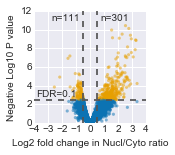

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set_style(style)
ax.scatter(nuclear_accum.logFC,
           -np.log10(nuclear_accum.PValue),
           edgecolor='none',
           rasterized=True,
           s=10,
           color=['#E69F00' if x else '#0C73B3' for x in nuclear_accum.index.isin(nuclear_ratio_sig.index)],
           alpha=0.5)
ax.axvline(0.5, ls='--', color='#555555')
ax.axvline(-0.5, ls='--', color='#555555')
ax.set_xlim(-4, 4)
ax.set_ylim(0, 12)
ax.axhline(2.4512, ls='--', color='#555555')
ax.annotate(s='FDR=0.1', xy=(-3.9, 2.6),
            fontname='Arial',
            size=10,
            horizontalalignment='left',
            verticalalignment='bottom')
ax.annotate(
    s='n={:d}'.format(len(nuclear_ratio_sig[nuclear_ratio_sig.logFC > 0])),
    xy=(0.75, 10.8),
    fontname='Arial',
    size=10,
    horizontalalignment='left',
    verticalalignment='bottom')
ax.annotate(
    s='n={:d}'.format(len(nuclear_ratio_sig[nuclear_ratio_sig.logFC < 0])),
    xy=(-0.75, 10.8),
    fontname='Arial',
    size=10,
    horizontalalignment='right',
    verticalalignment='bottom')
ax.set_xlabel('Log2 fold change in Nucl/Cyto ratio', size=10, labelpad=5)
ax.set_ylabel('Negative Log10 P value', size=10, labelpad=5)
ax.tick_params(axis='both', which='major', pad=2)
plt.savefig('/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/figures/volcano.svg', transparent=True)
plt.show()

### K-means clustering of increased N/C and decreased N/C genes (Fig S2):

In [11]:
def cluster_geneset(geneset, methylated_set, n_clusters, seed=None):
    geneset_scaled = geneset.copy()
    scaled_vals = scale(geneset_scaled.iloc[:, -12:].values, axis=1)
    geneset_scaled.iloc[:, -12:] = scaled_vals
    centroid, labels, *_ = k_means(scaled_vals, n_clusters, random_state=seed)
    geneset_scaled['cluster'] = labels + 1
    geneset_scaled['methylated'] = geneset_scaled.index.isin(methylated_set)
    plt.rcParams['svg.fonttype'] = 'none'
    sns.set(font='Arial', font_scale=1.2, style='white')
    geneset_long = pd.melt(
        geneset_scaled,
        id_vars=['hgnc_symbol', 'cluster', 'logFC'],
        value_vars=['CC1', 'CC2', 'CC3', 'CN1', 'CN2', 'CN3',
                    'VWC1', 'VWC2', 'VWC2', 'VWN1', 'VWN2', 'VWN3'],
        value_name='Relative Expression Change',
        var_name='Condition',
    )
    geneset_long['Condition'] = geneset_long.Condition.str[:-1]
    g = sns.FacetGrid(data=geneset_long, col='cluster')
    g.map(sns.pointplot, 'Condition', 'Relative Expression Change')
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.countplot(x='cluster',
                  data=geneset_scaled,
                  color='#E69F00',
                  ax=ax,
                  label='not m6A')
    sns.countplot(x='cluster',
                  data=geneset_scaled[geneset_scaled.methylated],
                  color='#0C73B3',
                  ax=ax,
                  label='m6A')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Cluster Size')
    plt.legend(loc=0)
    pca = PCA(2).fit(scaled_vals)
    comps = pca.transform(scaled_vals)
    centroid_comps = pca.transform(centroid)
    fig2, ax2 = plt.subplots()
    ax2.scatter(comps[:, 0], comps[:, 1], c=labels, cmap='Set1')
    for i, t in enumerate(centroid_comps, 1):
        ax2.annotate(s=i, xy=t, fontsize=25)
    return geneset_scaled, g, fig, fig2

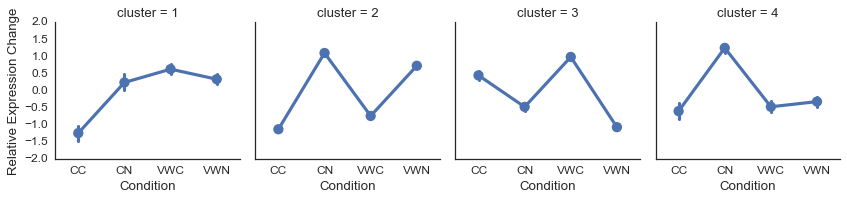

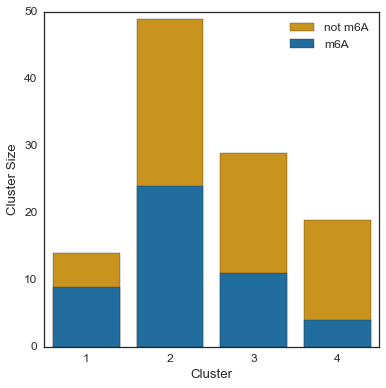

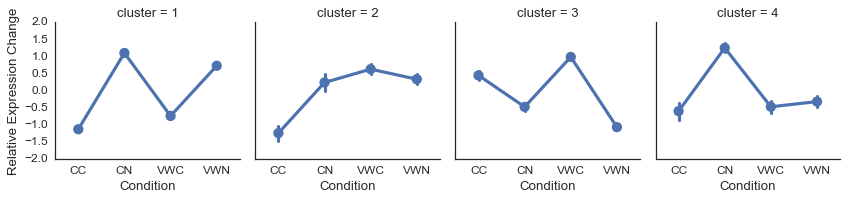

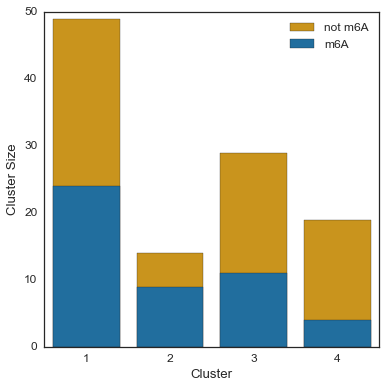

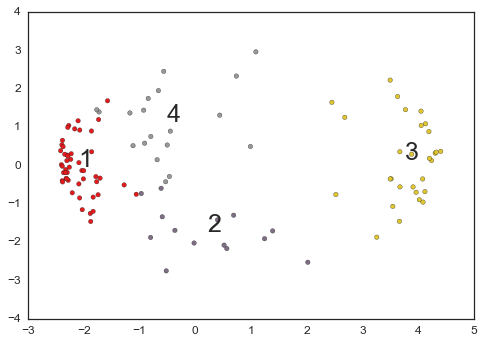

In [14]:
nuclear_deplete_sig = nuclear_accum[
    (nuclear_accum.logFC < -0.5) & (nuclear_accum.FDR < 0.1)]
methylated_set = set(m6a_cims.gene_id).union(m6a_cits.gene_id)
nd, *_ = cluster_geneset(nuclear_deplete_sig, methylated_set, 4)
plt.show()

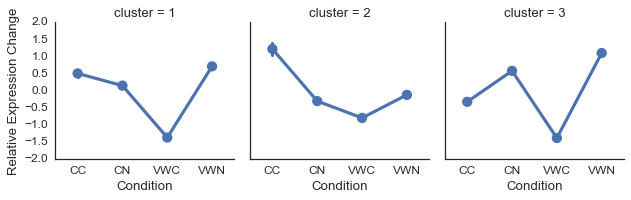

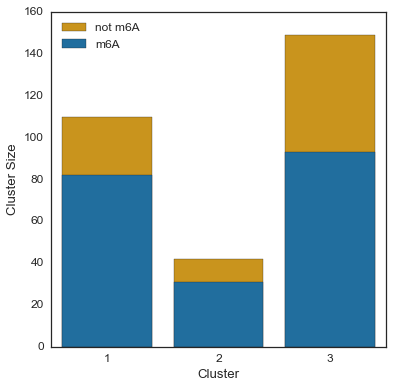

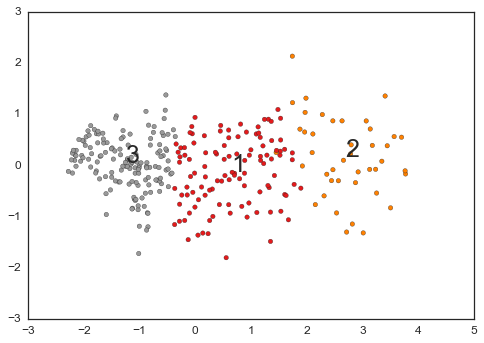

In [15]:
nuclear_accum_sig = nuclear_accum[
    (nuclear_accum.logFC > 0.5) & (nuclear_accum.FDR < 0.1)]
methylated_set = set(m6a_cims.gene_id).union(m6a_cits.gene_id)
na, *_ = cluster_geneset(nuclear_accum_sig, methylated_set, 3)
plt.show()

Hypergeometric tests for overlap of methylated genes and increased N/C genes

In [16]:
m6a_cims_genes = set(m6a_cims.gene_id)
nuc_acc_genes = set(nuclear_accum_sig.index.values)
print(len(m6a_cims_genes))
print(len(nuc_acc_genes))
print(len(all_genes))
print(len(m6a_cims_genes.intersection(nuc_acc_genes)))
p_val = stats.hypergeom.sf(
    len(m6a_cims_genes.intersection(nuc_acc_genes)) - 1,
    len(all_genes),
    len(m6a_cims_genes),
    len(nuc_acc_genes)
)
print(p_val)

4535
301
57736
153
1.29509704233e-86


In [17]:
m6a_cits_genes = set(m6a_cits.gene_id)
nuc_acc_genes = set(nuclear_accum_sig.index.values)
print(len(m6a_cits_genes))
print(len(nuc_acc_genes))
print(len(all_genes))
print(len(m6a_cits_genes.intersection(nuc_acc_genes)))
p_val = stats.hypergeom.sf(
    len(m6a_cits_genes.intersection(nuc_acc_genes)) - 1,
    len(all_genes),
    len(m6a_cits_genes),
    len(nuc_acc_genes)
)
print(p_val)

4082
301
57736
152
4.79219927313e-92


In [18]:
all_methylated = m6a_cims_genes.union(m6a_cits_genes)
print(len(all_methylated) / len(all_genes))
all_nuc_acc_methylated = all_methylated.intersection(nuc_acc_genes)
print(len(all_nuc_acc_methylated) / len(nuc_acc_genes))

0.10927324373008175
0.6843853820598007


In [19]:
p_val = stats.hypergeom.sf(
    len(all_nuc_acc_methylated) - 1,
    len(all_genes),
    len(all_methylated),
    len(nuc_acc_genes)
)
print(p_val)

1.65557658865e-124


In [20]:
methylated_intersection = m6a_cims_genes.intersection(m6a_cits_genes)
methylated_nuc_acc = methylated_intersection.intersection(nuc_acc_genes)

p_val = stats.hypergeom.sf(
    len(methylated_nuc_acc) - 1,
    len(all_genes),
    len(methylated_intersection),
    len(nuc_acc_genes)
)
print(p_val)

6.00529326842e-62


### Venn diagram of miCLIP overlap with increased N/C genes (Fig 3b):

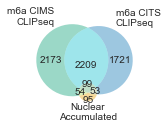

In [21]:
m6a_cims_genes = set(m6a_cims.gene_id)
m6a_cits_genes = set(m6a_cits.gene_id)
nuc_acc_genes = set(nuclear_accum_sig.index.values)

import itertools as it
fig, ax = plt.subplots(figsize=(2, 2))
v = vn.venn3(
    [m6a_cims_genes, m6a_cits_genes, nuc_acc_genes],
    set_colors=['#069E73', '#0C73B3', '#E69F00'],
    set_labels=['m6a CIMS\nCLIPseq',
                'm6a CITS\nCLIPseq',
                'Nuclear\nAccumulated'])
for label in it.chain(v.set_labels, v.subset_labels):
    label.set(size=10)
label = v.get_label_by_id('111')
pos = label.get_position()
#label.set(text='{}\np = {:.2g}'.format(label.get_text(), p_val),
#          position=(pos[0], pos[1] -0.04))
#for p in ['111', '110']:
#    subset_patch = v.get_patch_by_id(p)
#    subset_patch.set(edgecolor='#555555', lw=2, hatch='--')
plt.savefig('/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/figures/methylation_venn.svg', facecolor='none', transparent=True)
plt.show()

### Number of m6A sites per gene for increased N/C ratio vs other methylated (Fig 3C):

/home/matthew/anaconda3/envs/jupyter_python3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


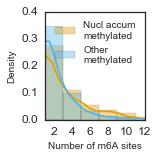

In [22]:
m6a = pd.concat([m6a_cims, m6a_cits])
m6a = m6a[~m6a.index.duplicated(keep='first')]
fig, ax = plt.subplots(figsize=(2, 2))
kde_kws = dict(bw=0.8)
sns.set_style(style)
sns.distplot(
    m6a[m6a.gene_id.isin(nuc_acc_genes)].groupby('gene_id').count().exon_no,
    ax=ax,
    color='#E69F00',
    label='Nucl accum\nmethylated',
    kde_kws=kde_kws,
    bins=np.arange(1, 12, 2))
sns.distplot(
    m6a[~m6a.gene_id.isin(nuc_acc_genes)].groupby('gene_id').count().exon_no,
    ax=ax,
    color='#56B4E9',
    label='Other\nmethylated',
    kde_kws=kde_kws,
    bins=np.arange(1, 12, 2))
plt.legend(fontsize=10)
ax.set_xlim(1, 12)
ax.set_xlabel('Number of m6A sites', size=10)
ax.set_ylabel('Density', size=10)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.tight_layout(pad=0)
plt.savefig('/home/matthew/Documents/analysis_notebooks/m6a/wtap_viril/zenodo/figures/de_gene_m6a_sites.svg',
            facecolor='none', transparent=True)
plt.show()

In [23]:
na = m6a_cims.gene_id.isin(nuc_acc_genes)
stats.mannwhitneyu(m6a_cims[~na].groupby('gene_id').count().exon_no,
                   m6a_cims[na].groupby('gene_id').count().exon_no)

MannwhitneyuResult(statistic=273696.5, pvalue=3.8590936811306733e-05)